In [2]:
import trackml
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from tools.detector import Detector
from tools.readpandas import Get_Momentum

from trackml.dataset import load_event, load_dataset
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


In [3]:
hits, cells, particles, truth = load_event('/Users/pjfox/Dropbox/NN/TrackML/train_100_events/event000001008')
detector = pd.read_csv('/Users/pjfox/Dropbox/NN/TrackML/detectors.csv')
# join hits with truth #
df=hits.merge(truth)
# extract length of each hit entry in cells, i.e. how many cells are read out in each hits
dftemp = pd.DataFrame(np.array(cells['hit_id'].value_counts().sort_index()),columns=['num_cells'])
print(min(dftemp['num_cells']),max(dftemp['num_cells']))
# add the length of cells column to database #
df['num_cells'] = dftemp['num_cells']

# seperate hits into bad (truth p_id == 0) and good (the others)
badhits=df.loc[df['particle_id'] == 0]
goodhits=df.loc[df['particle_id'] != 0]
print(len(badhits), len(goodhits))
print(1.0*len(badhits)/(1.0*len(goodhits)))
maxgood=max(goodhits['num_cells'])
maxbad=max(badhits['num_cells'])
print(maxgood,maxbad)
goodhits.head(5)
detector = Detector('/Users/pjfox/Dropbox/NN/TrackML/detectors.csv')

(1, 67)
(17496, 94371)
0.185395937311
(67, 62)


In [4]:
# select some hits in a particular volume with enough cells lit up
volid=8
cellhitslow=0
cellhitshigh=50
sizeofevent = 3 * cellhitshigh
selectedhits = np.array(goodhits.loc[(goodhits['volume_id'] == volid) & (goodhits['num_cells'] > cellhitslow)][['hit_id','tpx','tpy','tpz', 'layer_id', 'module_id']])
#goodhits.loc[(goodhits['volume_id'] == volid) & (goodhits['num_cells'] > cellhits)][['hit_id','tpx','tpy','tpz']].head()
print len(selectedhits)

24372


In [5]:
#make a list of all the cell info, ready for a NN to process, can be slow....
def makelistofhits(hit_id, lengthofinfo):
    cell_rows = cells['hit_id'] == hit_id
    cell_hits = cells[cell_rows].drop('hit_id',axis=1).sort_values(by=['value'],ascending=False)
    total = cell_hits["value"].sum()
    hit_row = hits['hit_id'] == hit_id
    volume_id = hits[hit_row]['volume_id'].item()
    layer_id = hits[hit_row]['layer_id'].item()
    module_id = hits[hit_row]['module_id'].item()
    detector._load_element_info(volid,layer_id,module_id)
    nCellsU = int(2*detector.module_maxhu/detector.pitch_u)
    nCellsV = int(2*detector.module_hv/detector.pitch_v)
    temp = (np.array(cell_hits)[:,0:3]*[1./nCellsU,1./nCellsV,1./total]).flatten()
    temp = temp[:min(len(temp), lengthofinfo)]
    return np.pad(temp,(0,lengthofinfo-len(temp)),'constant', constant_values=0)


list_of_hits = np.empty([len(selectedhits), sizeofevent])
for idx, hit_id in enumerate(selectedhits[:,0]):
    list_of_hits[idx:] = makelistofhits(hit_id, sizeofevent)

In [ ]:
np.savetxt("hits_max_50.txt", list_of_hits)
#list_of_hits = np.loadtxt("hits_1008_1_50.txt")

In [6]:
#convert truth direction to local coordinate frame, prepare training data
def rescale_by_pz(a):
    return [a[1]/a[3], a[2]/a[3]] #[a[0]/a[2], a[1]/a[2], 1]

def truthmom_to_uvw(a):
    b = detector.GlobalToLocalMom(a[1], a[2], a[3], volid, a[4], a[5])
    norm = np.linalg.norm(b)
    return [b[0], b[1], b[2]]/norm

directions = np.apply_along_axis(truthmom_to_uvw, 1, selectedhits)
x = list_of_hits
y = directions
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.4, random_state=67)



In [45]:
# the NN
NNmodel = Sequential()

NNmodel.add(Dense(units=x_train.shape[1], input_dim=x_train.shape[1]))
NNmodel.add(Activation('relu'))
NNmodel.add(Dense(units=x_train.shape[1]))
NNmodel.add(Activation('relu'))
NNmodel.add(Dense(units=int(0.25 * x_train.shape[1])))
NNmodel.add(Activation('relu'))
NNmodel.add(Dense(units=y_train.shape[1]))
#NNmodel.add(Activation('tanh'))          
NNmodel.compile(optimizer='adam',
              loss='cosine_proximity',
              metrics=['accuracy'])

In [46]:
#train it!
NNmodel_hist=NNmodel.fit(x_train, y_train, epochs=40000, batch_size=117, verbose=0)

In [47]:
NNmodel.evaluate(x_train, y_train)

13760/14623 [===========================>..] - ETA: 0s

[-0.24530806834839736, 0.7972372290309245]

In [75]:
#save it
#NNmodel.save('Vol8NN_test.h5')
NNmodel.load_weights('Vol8NN.h5')

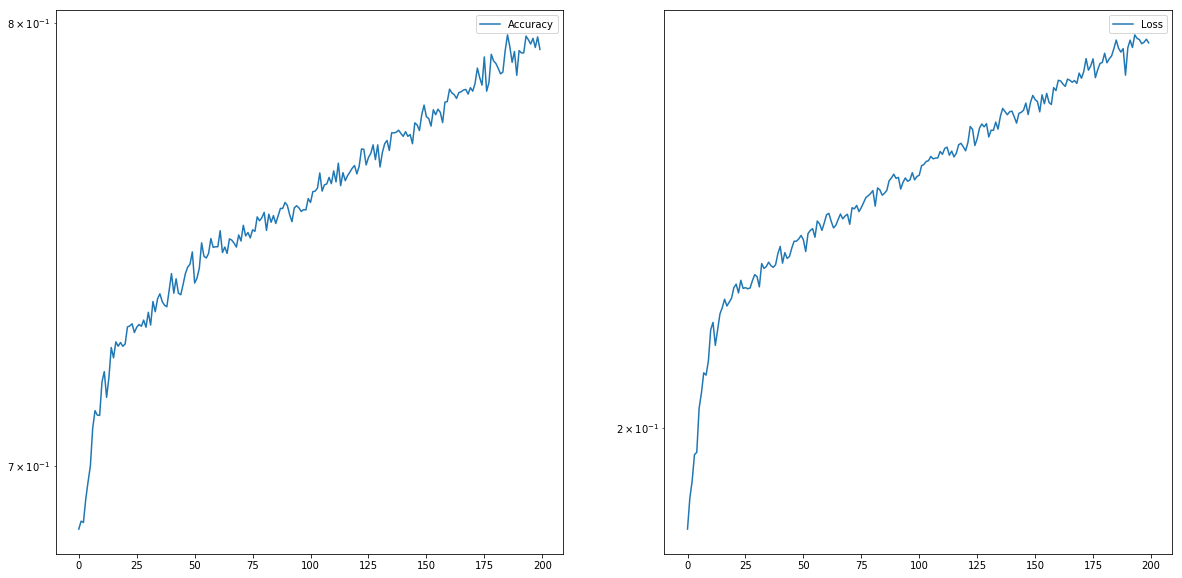

In [76]:
# accuracy etc
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_yscale('log')
ax.set_xscale('linear')
ax.plot(NNmodel_hist.history['acc'], label = 'Accuracy')
ax.legend()


ax2.set_yscale('log')
ax.set_xscale('linear')
ax2.plot(np.abs(NNmodel_hist.history['loss']), label = 'Loss')
ax2.legend()


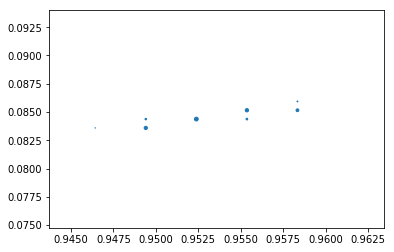

15797.0
0.9464285714285714 0.08359375000000001 0 -0.40188174341396954 -0.40437312507596174 0.8215676722138288
0.9464285714285714 0.08359375000000001 0 -0.19774824 -0.098232955 0.97531843
0.9204842695985174


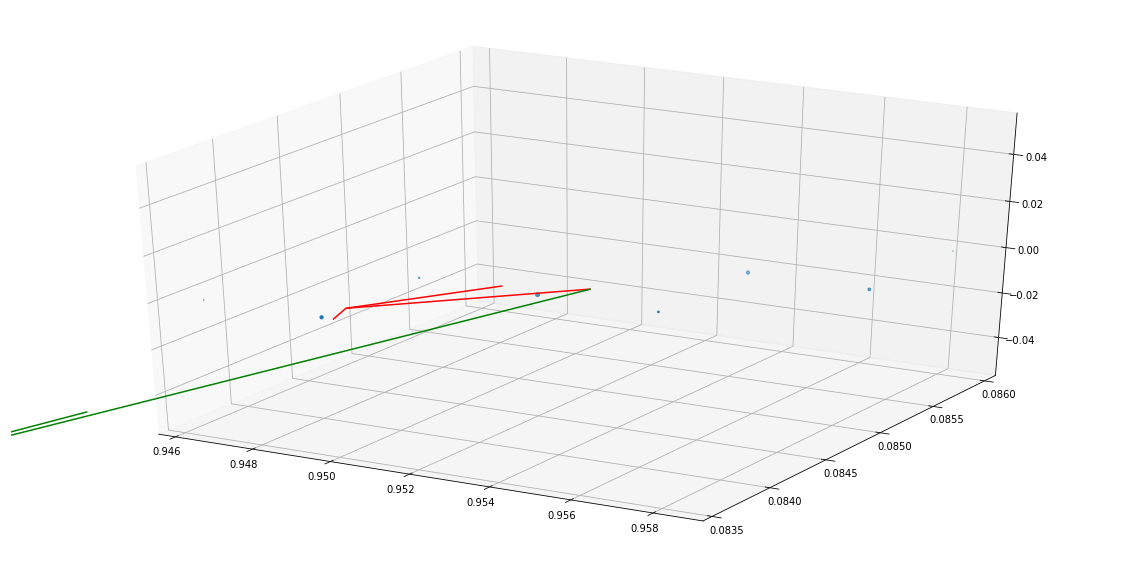

In [71]:
#look at an individual hit
ii=15
hitstemp = makelistofhits(selectedhits[ii,0],sizeofevent)
hitstemp = hitstemp[~(hitstemp == 0)]
hitstemp = np.reshape(hitstemp, (-1,3))
ss = 50 * hitstemp[:,2]
plt.scatter(hitstemp[:,0], hitstemp[:,1], s=ss)
plt.show()
hitwewant = selectedhits[ii,0]
print hitwewant
truedirection = truthmom_to_uvw(selectedhits[ii])
hitstemp = makelistofhits(selectedhits[ii,0],sizeofevent)
predicteddirection = NNmodel.predict(np.reshape(hitstemp,(1,sizeofevent)),verbose=0)[0]
predicteddirection = predicteddirection/np.linalg.norm(predicteddirection)
hitstemp = hitstemp[~(hitstemp == 0)]
hitstemp = np.reshape(hitstemp, (-1,3))
ss = 50 * hitstemp[:,2]
veclength = np.sqrt((hitstemp[:,0].max() - hitstemp[:,0].min())**2 + (hitstemp[:,1].max() - hitstemp[:,1].min())**2)
fig = plt.figure(figsize = (20,10))
ax2 = fig.gca(projection='3d')
ax2.quiver(hitstemp[:,0].mean(), hitstemp[:,1].mean(), 0, truedirection[0], truedirection[1], truedirection[2], length=veclength, normalize=True, color='g')
ax2.quiver(hitstemp[:,0].mean(), hitstemp[:,1].mean(), 0, predicteddirection[0], predicteddirection[1], predicteddirection[2], length=veclength, normalize=True, color='r')
ax2.scatter(hitstemp[:,0], hitstemp[:,1], np.zeros(len(hitstemp)), s=ss)
print hitstemp[:,0].min(), hitstemp[:,1].min(), 0, truedirection[0], truedirection[1], truedirection[2]
print hitstemp[:,0].min(), hitstemp[:,1].min(), 0, predicteddirection[0], predicteddirection[1], predicteddirection[2]
print ((np.array(predicteddirection) * np.array(truedirection)).sum())

In [20]:
#some helper functions to look at accuracy
def selectxy(low, high):
    x_selected = [x for x in x_test if (np.count_nonzero(x)/3 > low) and (np.count_nonzero(x)/3 <high)]
    y_selected = [y for x,y in zip(x_test, y_test) if (np.count_nonzero(x)/3 > low) and (np.count_nonzero(x)/3 <high)]
    return np.array(x_selected), np.array(y_selected)

selects = [select10, select20, select30, select40, select50] = [selectxy(l*10, (l+1)*10) for l in range(0,5)]
select50p = selectxy(50,20000)
selects.append(select50p)
print [len(x[0]) for x in selects]

def makehisto(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    predicted = NNmodel.predict(x,verbose=0)
    predicted = predicted/ np.linalg.norm(predicted, axis=1, keepdims=True)
    listofangles = np.arccos((predicted * y).sum(1))*180./np.pi
    meanlab = np.mean(listofangles)
    within20deg = 1.0* (np.sum(listofangles < 20) + np.sum(listofangles > 160))/len(listofangles)
    print [meanlab, within20deg, len(x)]
    return ax.hist(listofangles,bins=range(0,180,10), **kwargs)

[4576, 2626, 1002, 468, 251, 0]


[30.162084824707257, 0.49038461538461536, 4576]
[60.59007446346242, 0.4459253617669459, 2626]
[65.78842438342515, 0.624750499001996, 1002]
[68.18852271261426, 0.8012820512820513, 468]
[55.54087583059707, 0.8764940239043825, 251]
[46.25977363320795, 0.5246691968407016, 9749]


(array([2945., 1835.,  870.,  610.,  425.,  317.,  231.,  231.,  215.,
         195.,  201.,  213.,  219.,  257.,  323.,  327.,  303.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170]),
 <a list of 17 Patch objects>)

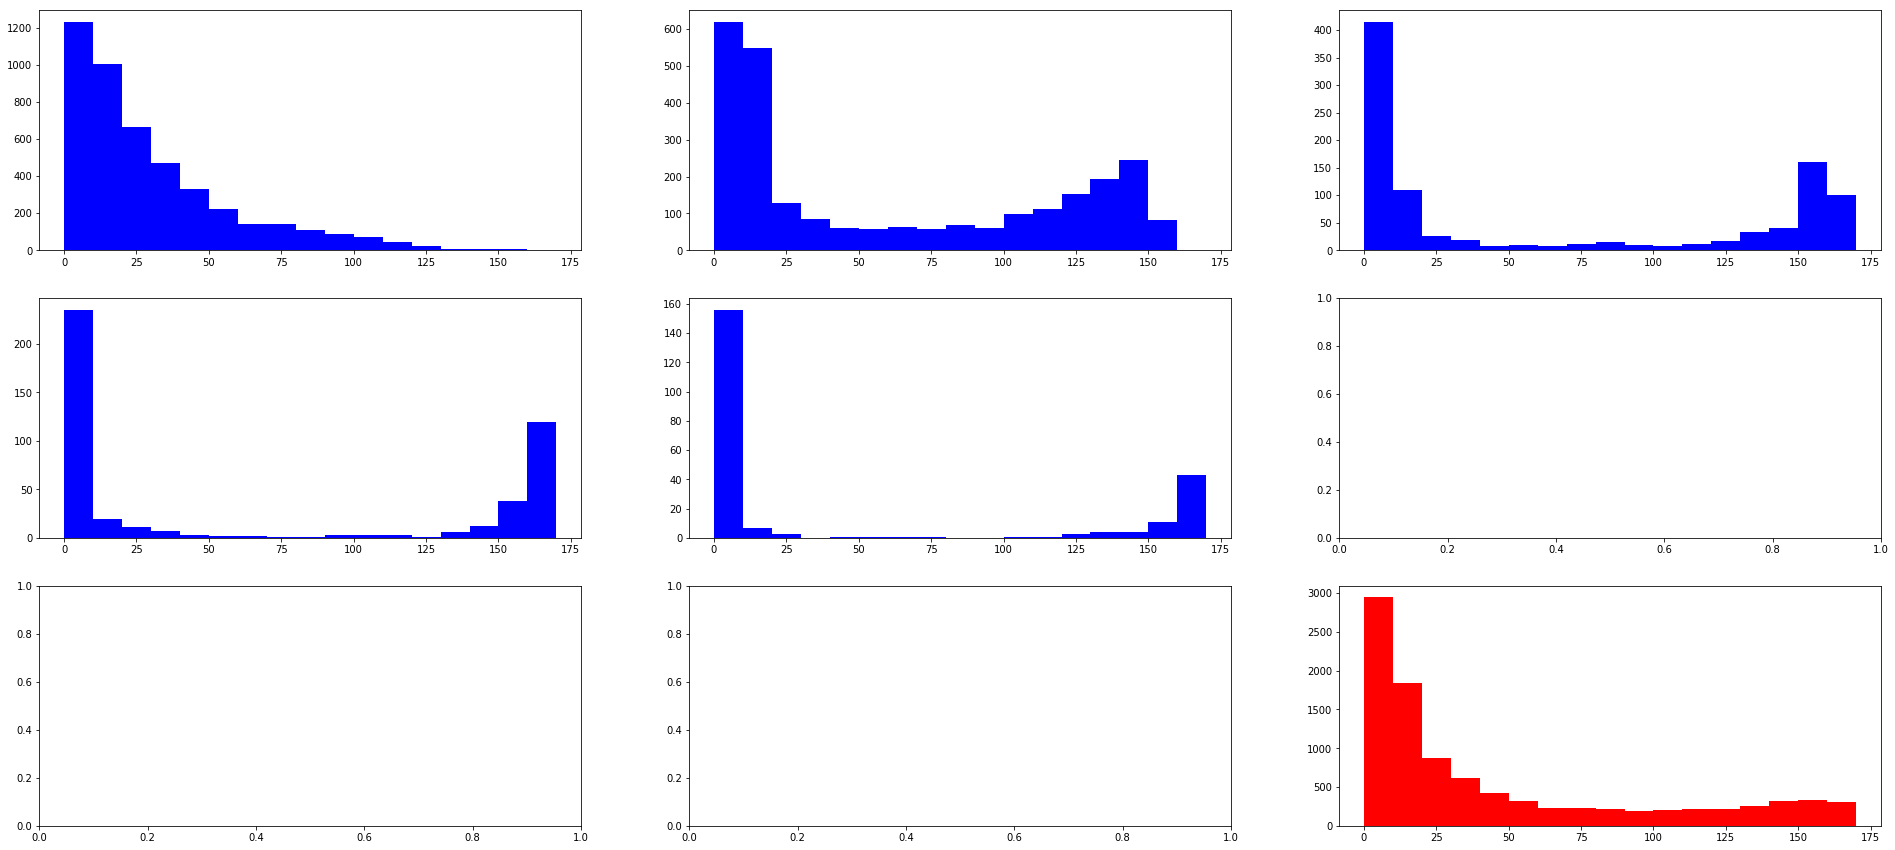

In [77]:
#plots of accuracy to see how pointing works depending on number of lit cells
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(33,15))
for sel, ax in zip(selects, [ax1, ax2, ax3, ax4, ax5, ax6]):
    if len(sel[0]) > 0:
        makehisto(sel[0], sel[1], ax, color='b')
selectall = selectxy(0, 20000)
makehisto(selectall[0], selectall[1], ax9, color='r')

In [ ]:
#TO DO
#may need to train for longer
#IS THIS ACCURATE ENOUGH??
#would be fun to look at forward prediction of an individual hit, see how many hits within N degrees, and then 
#compare the original hits with the backward prediction of all the N hits
#Can this info be combined with Jack, or used to find seeds?

## OLD STUFF BELOW

In [78]:
hits, cells, particles, truth = load_event('/Users/pjfox/Dropbox/NN/TrackML/train_100_events/event000001008')
hits_xyz = np.array(hits[['x','y','z']])
track_unique_ids = np.unique(truth.values[:,1])
#trackhitslist is a list.
#The nth entry in this list, is itself a list of the hit_ids corresponding to the nth truth-level track.
trackhitslist = [truth.values[truth.values[:,1] == track_unique_id,0] for track_unique_id in track_unique_ids[:500]]

#track_hits_list_xyz is a list, where each entry corresponds to a track.
#For each track, there is a list corresponding to the hits in that track.
#For each hit, there is a 3-vector of x,y,z coordinates.
track_hits_list_xyz = [hits_xyz[xx.astype(int)-1] for xx in  trackhitslist]

In [79]:
#find a track that passes through volume in question
tracks
temp=np.array([ [idx, xx[0],np.array(hits.loc[hits['hit_id'] == xx[0]]['volume_id'])[0]] for idx, xx in enumerate(trackhitslist)])
trackid, hitid, dummy = temp[np.where(temp[:,2] == volid)][0:,][ii].astype(int)
trackid, hitid, dummy

NameError: name 'tracks' is not defined

In [ ]:
particlewewant = truth.loc[truth['hit_id']==hitwewant]['particle_id'].item()
allhitsontrack = truth.values[truth.values[:,1] == particlewewant,0]
allhitsinvol = [xx for xx in allhitsontrack if hits.loc[hits['hit_id'] == xx]['volume_id'].item() == volid]
allcellsontrack = np.reshape([makelistofhits(xx) for xx in allhitsinvol],(-1,sizeofevent))
layers_modules = np.array([np.array(hits.loc[hits['hit_id'] == xx].values[:,5:7])[0] for xx in allhitsinvol])
alllocaldirections = NNmodel.predict(allcellsontrack,verbose=0)
alllocaldirections = alllocaldirections/ np.linalg.norm(alllocaldirections)

detector.LocalToGlobalMom(alllocaldirections[:,0], alllocaldirections[:,1], alllocaldirections[:,2], volid, layers_modules[:,0], layers_modules[:,1])

#alllocaldirections[:,0]











In [ ]:
#find a particular track by a hit_id in it
trackid, allhits = [ [idx, xx] for idx, xx in enumerate(trackhitslist) if hitwewant in xx][0]

In [ ]:
firsthit=trackhitslist[trackid][0]
thisevent = makelistofhits(firsthit)
predicteddirection = np.array(NNmodel.predict(thisevent,verbose=0)[0])
predicteddirection = detector.LocalToGlobalMom(predicteddirection[0], predicteddirection[1], predicteddirection[2], volid, layer_id, module_id)
predicteddirection = predicteddirection/ np.linalg.norm(predicteddirection)

In [ ]:
starthit = track_hits_list_xyz[trackid][0]
def dist_to_direction(start, end, direction):
    if np.dot(start-end,start-end) < 0.0001:
        return 0
    startnp = np.array(start)
    endnp = np.array(end)
    costheta = np.dot(end-start,direction)/np.sqrt(np.dot(end-start, end-start))
    hypo = np.sqrt(np.dot(end-start, end-start))
    if costheta * costheta > 1:
#        print start, end, costheta, np.dot(start-end,start-end)
        return 0
    return hypo * np.sqrt(1. - costheta * costheta) * np.sign(costheta)
    
closepoints = np.array([ xxx for xxx in hits_xyz if (dist_to_direction(starthit, xxx, predicteddirection) < 50) and (dist_to_direction(starthit, xxx, predicteddirection) > 0)])
print len(closepoints)


In [ ]:
pltx, plty, pltz = track_hits_list_xyz[trackid][:,2], track_hits_list_xyz[trackid][:,0], track_hits_list_xyz[trackid][:,1]
veclength = 1000

fig = plt.figure(figsize = (20,10))
ax2 = fig.gca(projection='3d')
#ax2.scatter(truth[:5000][['tz']], truth[:5000][['tx']], truth[:5000][['ty']], color='gray')
ax2.scatter(pltx, plty, pltz, color = 'r')
ax2.scatter(pltx[0], plty[0], pltz[0], s=100, color = 'black')
ax2.quiver(pltx[0], plty[0], pltz[0], predicteddirection[2], predicteddirection[0], predicteddirection[1], length=veclength, normalize=True, color='b')
ax2.scatter(closepoints[:,2], closepoints[:,0], closepoints[:,1], color='gray')
ax2.set_xlim(-3000,3000)
ax2.set_ylim(-1000,1000)
ax2.set_zlim(-1000,1000)

In [ ]:
plt.figure(figsize=(20,18))
ax1 = plt.subplot2grid((3,3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((3,3), (0, 1), colspan=2)
ax3 = plt.subplot2grid((3,3), (1, 0), rowspan=2)
ax1.scatter(closepoints[:,1], closepoints[:,0], color='gray')
ax1.scatter(track_hits_list_xyz[trackid][:,1],track_hits_list_xyz[trackid][:,0], color='r')
ax1.scatter(track_hits_list_xyz[trackid][:,1][0],track_hits_list_xyz[trackid][:,0][0], s=100, color = 'black')
ax1.quiver(track_hits_list_xyz[trackid][:,1][0],track_hits_list_xyz[trackid][:,0][0], predicteddirection[1], predicteddirection[0], color='b',scale=3, scale_units='width')
#
ax2.scatter(closepoints[:,2], closepoints[:,0], color='gray')
ax2.scatter(track_hits_list_xyz[trackid][:,2],track_hits_list_xyz[trackid][:,0], color='r')
ax2.scatter(track_hits_list_xyz[trackid][:,2][0],track_hits_list_xyz[trackid][:,0][0], s=100, color = 'black')
ax2.quiver(track_hits_list_xyz[trackid][:,2][0],track_hits_list_xyz[trackid][:,0][0], predicteddirection[2], predicteddirection[0], color='b',scale=3, scale_units='width')
#
ax3.scatter(closepoints[:,1], closepoints[:,2], color='gray')
ax3.scatter(track_hits_list_xyz[trackid][:,1],track_hits_list_xyz[trackid][:,2], color='r')
ax3.scatter(track_hits_list_xyz[trackid][:,1][0],track_hits_list_xyz[trackid][:,2][0], s=100, color = 'black')
ax3.quiver(track_hits_list_xyz[trackid][:,1][0],track_hits_list_xyz[trackid][:,2][0], predicteddirection[1], predicteddirection[2], color='b',scale=3, scale_units='width')    


ax1.set_ylabel("x / mm")
ax1.set_xlabel("y / mm")
ax2.set_ylabel("x / mm")
ax2.set_xlabel("z / mm")
ax3.set_ylabel("z / mm")
ax3.set_xlabel("y / mm")
ax3.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
plt.quiver(0,0,0.7,0.7,scale=3, scale_units='width')

In [ ]:
crap[0]

In [ ]:
hits_xyz = np.array(hits[['x','y','z']])
track_unique_ids = np.unique(truth.values[:,1])
trackhitslist = [truth.values[truth.values[:,1] == track_unique_id,0] for track_unique_id in track_unique_ids[:100]]
track_hits_list_xyz = [hits_xyz[xxx.astype(int)-1] for xxx in  trackhitslist]


In [ ]:
trackhitslist[10][1]